# Transit fitting

This tutorial demonstrates how to use `gallifrey` for background modelling, with the goal of fitting/sampling transit parameters in exoplanet transit light curves. We will see that we can use the predictive distribution that we obstain from the `gallifrey` SMC sampler as the objective for the transit parameter fit, which means we do not have to fit the Gaussian Process parameter and transit parameter together, which reduces the computation time we need to sample the transit parameter posterior. To stay within the JAX ecosystem, we will use `jaxoplanet` to model the transit signal, and `blackjax` for sampling.

## Notebook setup

First, we again set up the computational environment. We set the `XLA_FLAGS` to register all available cores as independent devices.

In [1]:
import multiprocessing
import os

os.environ["XLA_FLAGS"] = (
    f"--xla_force_host_platform_device_count={multiprocessing.cpu_count()}"
)

In [2]:
# import libraries
import pathlib
from collections import OrderedDict

import blackjax
import jax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from blackjax.util import run_inference_algorithm
from jax import numpy as jnp
from jax import random as jr
from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet.orbits import TransitOrbit

from gallifrey import GPConfig, GPModel, LinearSchedule
from gallifrey.kernels import Matern32Atom, ProductOperator, RBFAtom, SumOperator

gallifrey: Setting flag `JAX_ENABLE_X64` to `True`
gallifrey: Setting flag `OMP_NUM_THREADS` to `1`


In [3]:
# notebook settings

# making the plots pretty
sns.set_theme(
    context="poster",
    style="ticks",
    palette="rocket",
    font_scale=1,
    rc={
        "figure.figsize": (16, 7),
        "axes.grid": False,
        "font.family": "serif",
        "text.usetex": True,
        "lines.linewidth": 5,
        # "axes.grid": True,
    },
)

# setting saving defaults
save_figures = True
load_models = True  # load pre-trained models,

# set saving paths
path = pathlib.Path.cwd().parent
figure_directory = path / "figures/transit_fitting/"
if not figure_directory.exists():
    figure_directory.mkdir(parents=True)

# set a random key for for this notebook
rng_key = jr.PRNGKey(7)

## Data preparation

We begin by loading the light curve data with a transit signal. We will use a light curve provided by the _PLATO Solar-like Light-curve Simulator_ (<a href="https://arxiv.org/abs/1903.02747/">arXiv link</a>). The data contains a simulated PLATO observation of 16 Cyg B (KIC 12069449), a main sequence star comparable in mass and radius to the Sun. 

In [4]:
lightcurve = pd.read_csv(path / "data/PSLS/0012069449_with_transit.csv").rename(
    columns={"time [d]": "Time [Days]", "flux [ppm]": "Flux [ppm]"}
)

We select a segment of the light curve containing a single transit and create masks to identify the transit region.


In [5]:
# select a segment with a single transit
single_transit_mask = (lightcurve["Time [Days]"] > 49.425) & (
    lightcurve["Time [Days]"] < 49.58
)

# identify the transit region
transit_mask = (lightcurve["Time [Days]"] > 49.49) & (lightcurve["Time [Days]"] < 49.51)

single_transit_lc = lightcurve[single_transit_mask]
single_transit_without_transit = lightcurve[single_transit_mask & ~transit_mask]

# convert to jax arrays for training
xtrain = jnp.array(single_transit_without_transit["Time [Days]"])
ytrain = jnp.array(single_transit_without_transit["Flux [ppm]"])

Let's visualize the full light curve, and our selected transit.

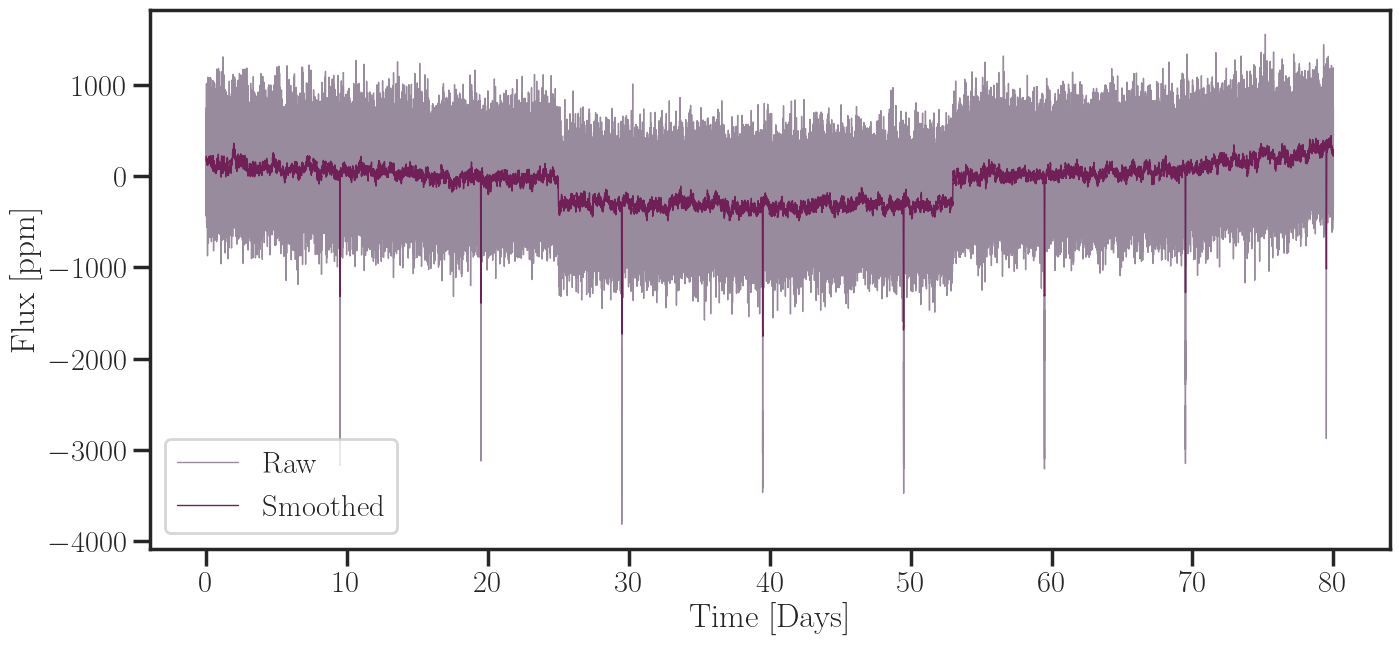

In [6]:
lightcurve_plot = sns.lineplot(
    data=lightcurve,
    x="Time [Days]",
    y="Flux [ppm]",
    alpha=0.5,
    linewidth=1,
    label="Raw",
)
# add smoothed lightcurve
sns.lineplot(
    data=lightcurve.rolling(window=100).mean(),
    x="Time [Days]",
    y="Flux [ppm]",
    linewidth=1,
    label="Smoothed",
)
if save_figures:
    plt.savefig(figure_directory / "lightcurve_plot.pdf", bbox_inches="tight")

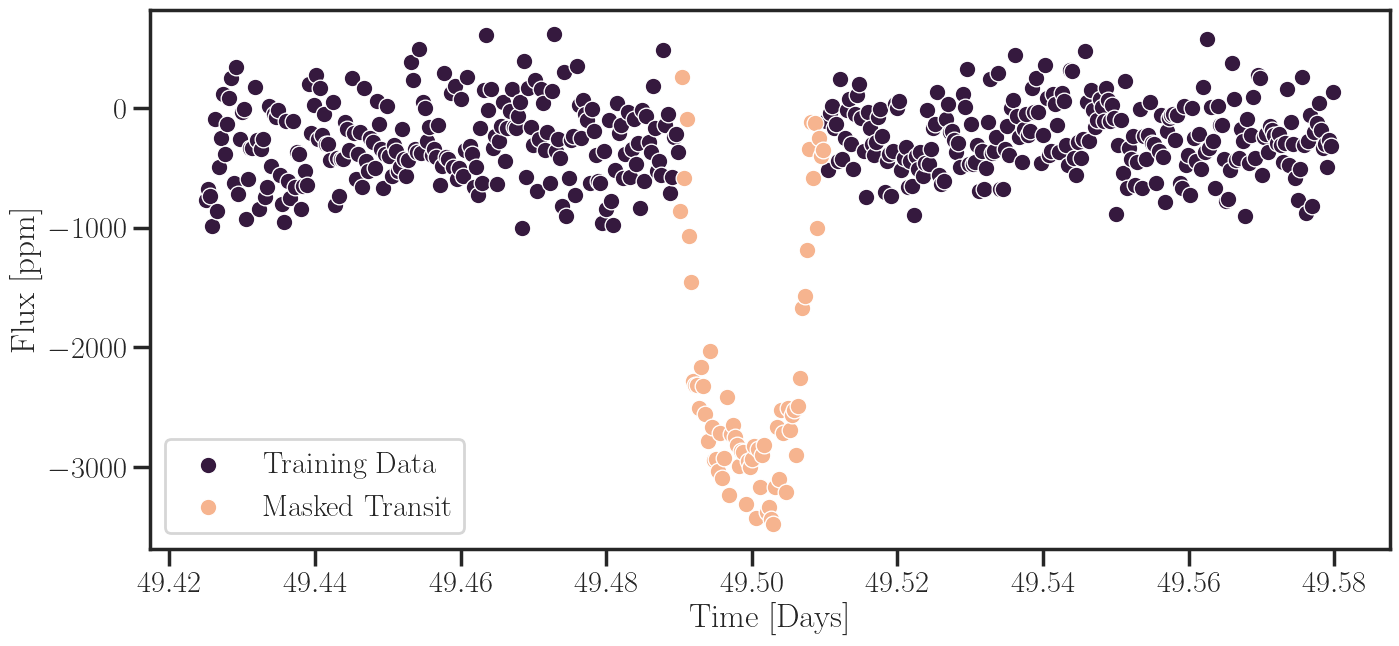

In [7]:
# visualize the transit
data_plot = sns.scatterplot(
    x=single_transit_lc["Time [Days]"][~transit_mask],
    y=single_transit_lc["Flux [ppm]"][~transit_mask],
    label="Training Data",
    color="C0",
)
sns.scatterplot(
    x=single_transit_lc["Time [Days]"][transit_mask],
    y=single_transit_lc["Flux [ppm]"][transit_mask],
    label="Masked Transit",
    color="C5",
    ax=data_plot,
)
if save_figures:
    plt.savefig(figure_directory / "lightcurve_segment_plot.pdf", bbox_inches="tight")

## `gallifrey` Gaussian Process model setup

To model the stellar background (the underlying trend apart from the transit), we'll use our Gaussian Process. Looking at the data, we can see that the light curve is mostly smooth, and changes gradually. To model this, we will include a RBF kernel as part of atomic kernels for the `gallifrey` model. To account for more jagged features on smaller time scales, we also add a Matérn 3/2 kernel to the library.

In [8]:
config = GPConfig(
    max_depth=2,
    atoms=[RBFAtom(), Matern32Atom()],
    operators=[SumOperator(), ProductOperator()],
    node_probabilities=jnp.array([1.0, 1.0, 0.5, 0.5]),
)

Now we create our GP model instance:

In [9]:
# create GP model instance
key, model_key = jr.split(rng_key)
gpmodel = GPModel(
    model_key,
    x=xtrain,
    y=ytrain,
    num_particles=16,
    config=config,
)

## Model training with Sequential Monte Carlo

Next, we'll fit the model using the SMC sampler.

In [10]:
# run the model

if load_models is False:
    key, smc_key = jr.split(key)
    final_smc_state, history = gpmodel.fit_smc(
        smc_key,
        annealing_schedule=LinearSchedule().generate(len(xtrain), 20),
        n_mcmc=75,
        n_hmc=10,
        verbosity=1,
    )
else:
    final_smc_state = gpmodel.load_state(
        str(path / "model_checkpoints/psls_deep/final_state.pkl")
    )
    history = gpmodel.load_state(str(path / "model_checkpoints/psls_deep/history.pkl"))

# update the model with the new state
gpmodel = gpmodel.update_state(final_smc_state)

## GP predictive distribution

Now that our GP model is trained, we can use it to predict the underlying stellar variability across the light curve segment:

In [ ]:
# predict values for all data in the segement (including the transit), and transform the data to the normalised space
xall_norm = gpmodel.x_transform(single_transit_lc["Time [Days]"].values)

We can use the predictive distribution that we obtain from the model as the objective for the transit fitting. In this way, we include the learned characteristics of the time series, including correlations, into the fitting process. Since the computational demand (both in time and memory) for calculating the log probability increases with the number of particles in the sample, we will use only a subset of particles for this. The `get_mixture_distribution` method contains a convenience parameter to sample a subset of particles from the full ensemble and construct the mixture distribution using this subset. In this case, we have to pass a value for `num_particles` and a random `key` for the sampling.

In [12]:
key, mixture_key = jr.split(rng_key)

# now we can get the predictive distribution, using subset of the particles
predictive_gmm = gpmodel.get_mixture_distribution(
    xall_norm,
    num_particles=8,
    key=mixture_key,
)

Let's visualize the GP model fit:

In [13]:
# calculate the mean and std of the predictive distribution
predictive_mean = predictive_gmm.mean()
predictive_stddev = predictive_gmm.stddev()

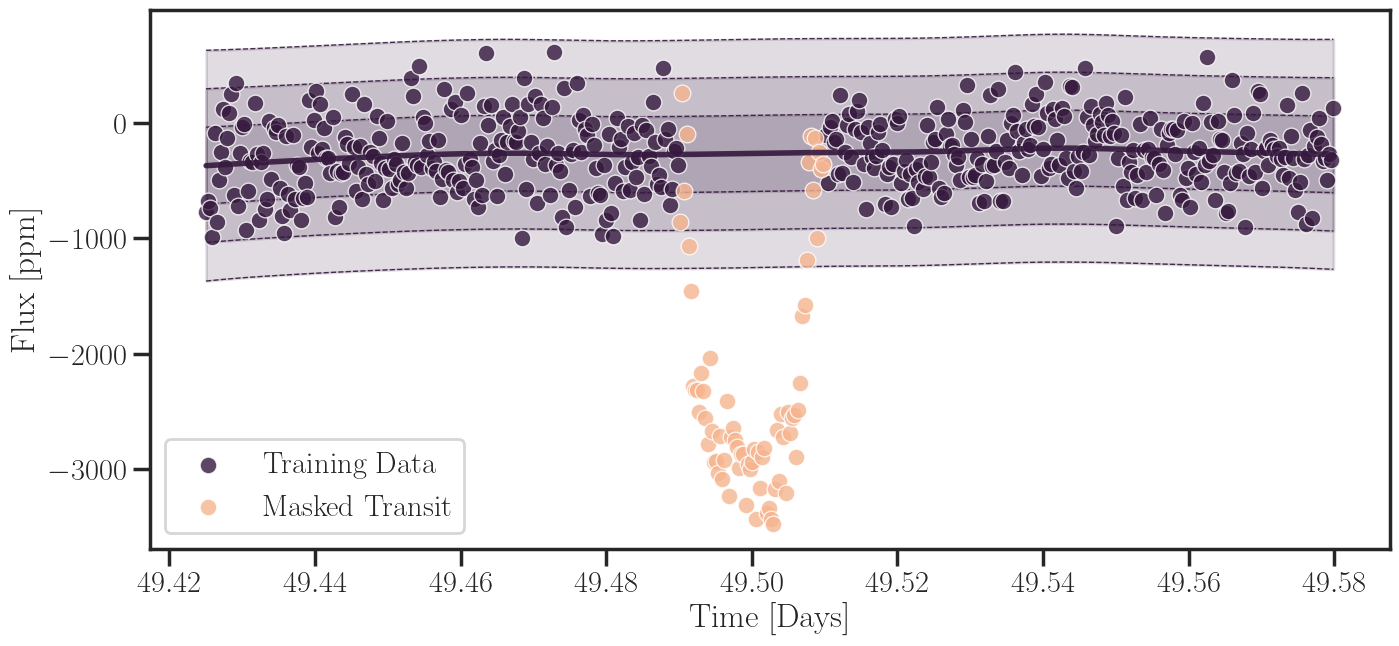

In [14]:
# plot the data
figure, prediction_plot = plt.subplots()

for mask, color, label in zip(
    [~transit_mask, transit_mask],
    ["C0", "C5"],
    ["Training Data", "Masked Transit"],
):
    sns.scatterplot(
        x=single_transit_lc["Time [Days]"][mask],
        y=single_transit_lc["Flux [ppm]"][mask],
        label=label,
        color=color,
        zorder=10,
        alpha=0.8,
        ax=prediction_plot,
    )

# plot predictive mean and std dev
for offset, lw, ls, flag in [
    (0, 4, None, 1),
    (predictive_stddev, 1, "--", 1),
    (-predictive_stddev, 1, "--", 0),
    (2 * predictive_stddev, 1, "--", 1),
    (-2 * predictive_stddev, 1, "--", 0),
    (3 * predictive_stddev, 1, "--", 1),
    (-3 * predictive_stddev, 1, "--", 0),
]:
    sns.lineplot(
        x=single_transit_lc["Time [Days]"],
        y=gpmodel.y_transform.unapply(predictive_mean + offset),
        color="C0",
        ax=prediction_plot,
        linewidth=lw,
        linestyle=ls,
        alpha=0.9,
        zorder=100 if ls is None else None,
    )
    if flag:
        prediction_plot.fill_between(
            single_transit_lc["Time [Days]"],
            gpmodel.y_transform.unapply(predictive_mean + offset),
            gpmodel.y_transform.unapply(predictive_mean - offset),
            alpha=0.15,
            color="C0",
        )

if save_figures:
    plt.savefig(figure_directory / "lc_prediction_plot.pdf", bbox_inches="tight")

## Transit model with `jaxoplanet`


With our GP model capturing the stellar background, we can now create a transit model using the `jaxoplanet` package. We will fix the period, impact parameter and limb darkening to their true values, and only fit the transit duration, transit time and transit depth.


In [15]:
def transit_model(params, period=10.0, impact_param=0.0, limb_dark=[0.25, 0.75]):
    """
    Creates a transit light curve model with given parameters.

    Parameters:
    ----------
    params : dict
        Dictionary containing the transit parameters:
        - duration: Transit duration
        - t0: Time of transit center
        - r: Planet-to-star radius ratio
    period : float, optional
        Orbital period in days (default: 10.0)
    impact_param : float, optional
        Impact parameter (default: 0.0)
    limb_dark : list, optional
        Limb darkening coefficients (default: [0.25, 0.75])

    Returns:
    -------
    jnp.ndarray: Model light curve
    """
    orbit = TransitOrbit(
        period=jnp.array(period),
        duration=params["duration"],
        time_transit=params["t0"],
        impact_param=jnp.array(impact_param),
        radius_ratio=params["r"],
    )
    return limb_dark_light_curve(orbit, jnp.array(limb_dark))(xall_norm)

## Combining GP background and transit model

Now combine our GP background model with the transit model. We make the following assumption: If we can determine the correct transit parameter and substract the transit light curve from the data, the remaining residuals should be well described the the GP background model. Since we took care to fit the GP model with a masked transit, we do not have to worry about having overfit the transit either. We can therefore use the predictive probability distribution the we obtained from the SMC sampling as our objective for the residuals.

Note that this is different from most transit fitting recipes in the literature, where one would fit the transit parameter and GP parameters together to avoid overfitting on the GP parameter. For us, the SMC yields an estimate of the GP parameter (and structure) posterior, so we don't have to worry about overfitting the Gaussian Process. This reduces the calculation to simply calculating the transit light curve and evaluating the predictive log probability, which is much less computational demanding that fitting the GP parameters at the same time.

In [16]:
@jax.jit
def objective(params):
    """
    Objective function for transit fitting.

    Calculates the log probability of the residuals (data - transit model)
    under the GP model.

    Parameters:
    ----------
    params : dict
        Transit parameters

    Returns:
    -------
    float: Log probability
    """
    transit_light_curve = transit_model(params) * 1e6  # in ppm

    residuals = single_transit_lc["Flux [ppm]"].values - transit_light_curve
    log_prob = predictive_gmm.log_prob(gpmodel.y_transform(residuals))
    return log_prob

## Sampling the posterior using `blackjax`

For simplicity, we will assume flat priors over the transit parameters. This makes our objective identical to the posterior distribution that we want to sample from.  We'll use MCMC (specifically, the NUTS sampler from `blackjax`) to sample the transit parameter posterior distribution. We initialize the sampler with reasonable initial guesses. We will make these guesses in the transformed space of the `GPModel` instance, rather than the original space, since we're passing the transformed time values `xall_norm` to the `transit_model`, rather than the original data.

In [17]:
initial_guess = OrderedDict(
    {
        "r": jnp.array(0.06),
        "t0": gpmodel.x_transform(jnp.array(49.502)),
        "duration": jnp.array(0.02)
        * gpmodel.x_transform.slope,  # scale but don't shift
    }
)

Next, we can do the sampling. We will use `blackjax`'s window adaption feature to set the NUTS hyperparameter and perform the the MCMC burn-in. Then we run the sampling

In [18]:
# parameter adaption and burn-in
warmup = blackjax.window_adaptation(blackjax.nuts, objective, progress_bar=True)
key, warmup_key, sample_key = jax.random.split(key, 3)
(burned_in_state, nuts_parameters), _ = warmup.run(
    warmup_key, initial_guess, num_steps=1000
)

# sampling
nuts_sampler = blackjax.nuts(objective, **nuts_parameters)

final_state, (history, info) = run_inference_algorithm(
    rng_key=sample_key,
    inference_algorithm=nuts_sampler,
    num_steps=int(1e4),
    initial_state=burned_in_state,
    progress_bar=True,
)

Running window adaptation


We convert the MCMC chain to a dataframe for easier plotting:

In [21]:
mcmc_df = pd.DataFrame(
    jnp.stack(list(history.position.values())).T, columns=list(initial_guess.keys())
).rename(
    columns={
        "r": "Radius Ratio",
        "t0": "Time of Transit Center [Days]",
        "duration": "Transit Duration [Days]",
    }
)

# convert the time values back to the original space
mcmc_df["Time of Transit Center [Days]"] = gpmodel.x_transform.unapply(
    mcmc_df["Time of Transit Center [Days]"].values
)
mcmc_df["Transit Duration [Days]"] = (
    mcmc_df["Transit Duration [Days]"] / gpmodel.x_transform.slope
)


mcmc_df.head()

,Radius Ratio,Time of Transit Center [Days],Transit Duration [Days]
0,0.046613,49.499464,0.017472
1,0.046589,49.499458,0.017591
2,0.046472,49.499429,0.017539
3,0.046740,49.499498,0.017468
4,0.045629,49.499517,0.017095


And finally make a corner plot of the MCMC samples:

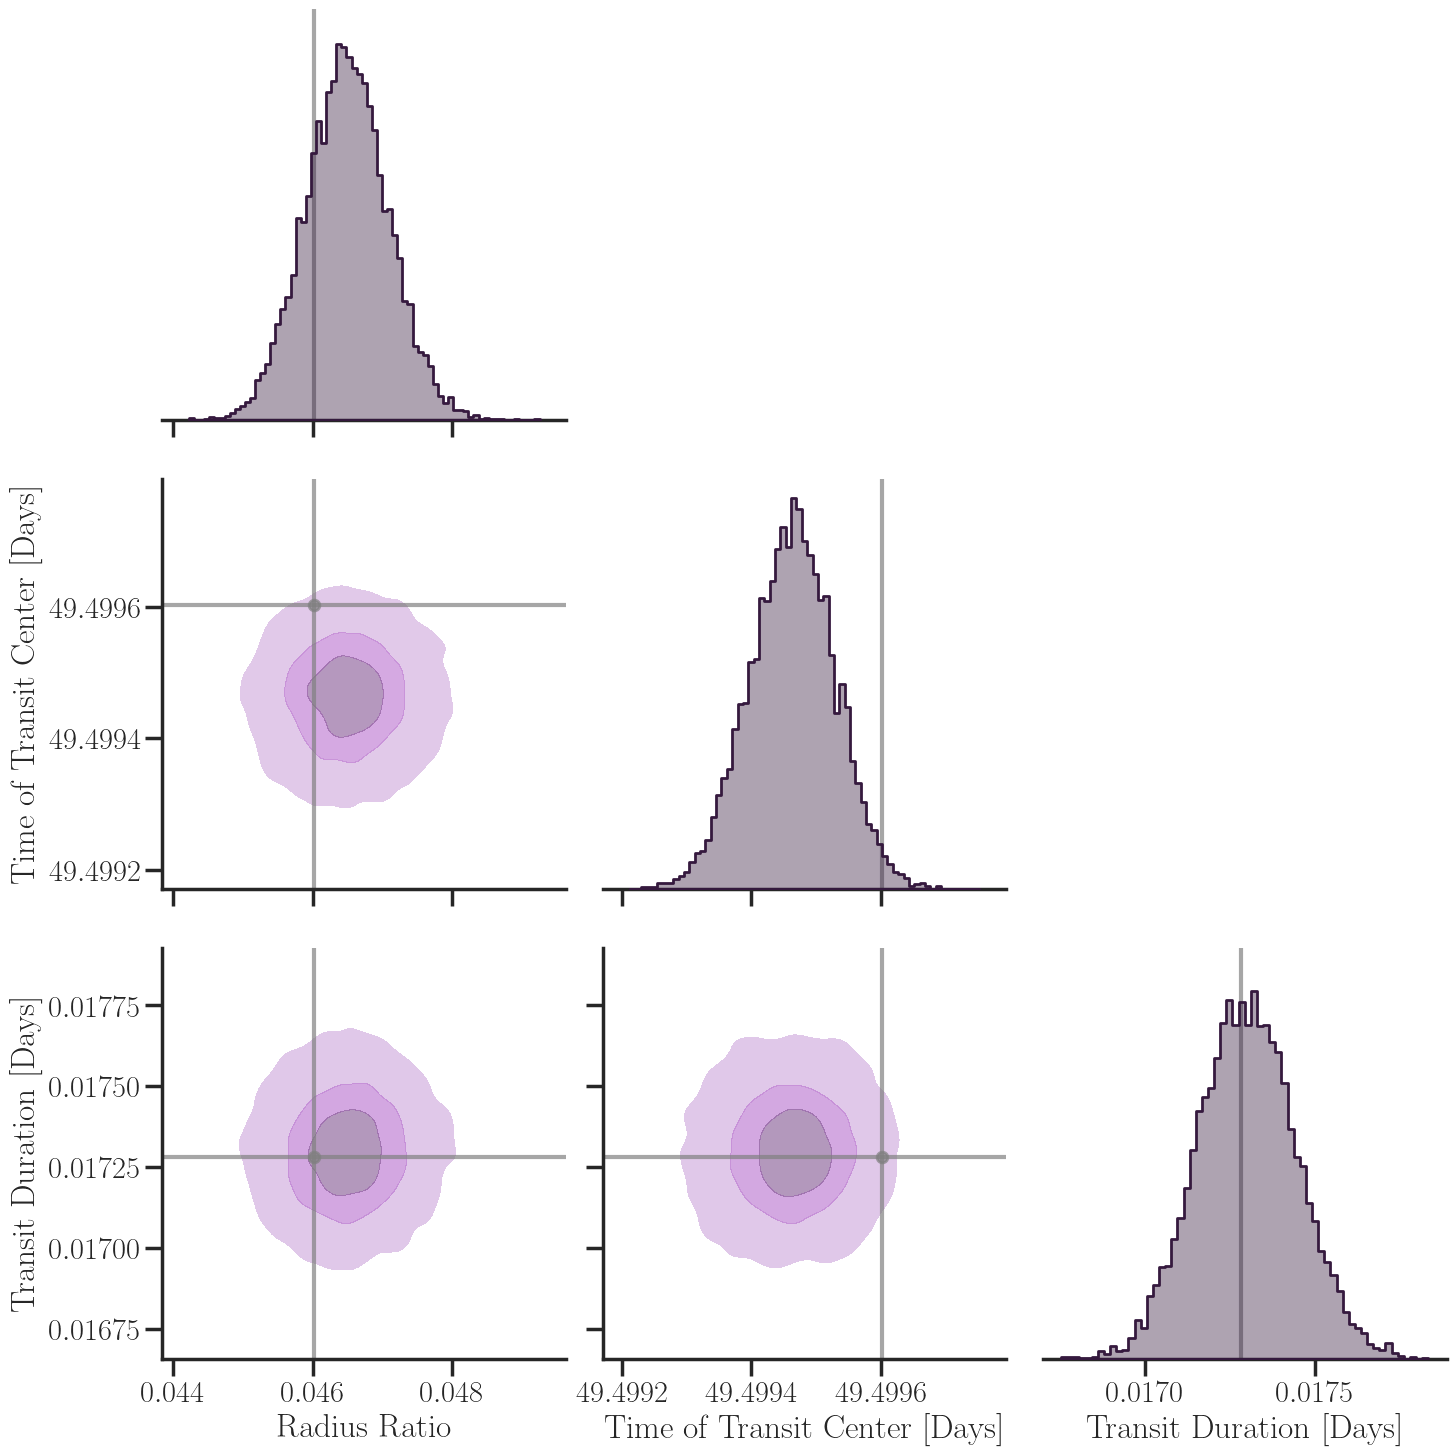

In [20]:
corner_plot = sns.pairplot(
    mcmc_df,
    corner=True,
    diag_kind="hist",
    kind="kde",
    diag_kws={"element": "step", "alpha": 0.4},
    plot_kws={"fill": True, "alpha": 0.6, "levels": 4},
    height=5,
)
# disable scientific notation
for ax in corner_plot.axes.flatten():
    if ax is not None:
        ax.ticklabel_format(useOffset=False, style="plain")

# add ground truth
ground_truth = [0.046013, 49.499602, 0.01728]
for i in range(3):
    for j in range(3):
        if corner_plot.axes[i, j]:
            corner_plot.axes[i, j].axvline(
                ground_truth[j],
                color="grey",
                alpha=0.7,
                linewidth=3,
            )
            if i != j:
                corner_plot.axes[i, j].axhline(
                    ground_truth[i],
                    color="grey",
                    alpha=0.7,
                    linewidth=3,
                )
                corner_plot.axes[i, j].scatter(
                    ground_truth[j],
                    ground_truth[i],
                    color="grey",
                    alpha=0.7,
                    s=60,
                )


if save_figures:
    plt.savefig(figure_directory / "corner_plot.pdf", bbox_inches="tight")